In [1]:
import time

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# 自作関数
from dataload.data_load import data_load
from func.my_func import *

In [29]:
keio_df = pd.read_csv('../../../野球部データ収集/keio_data/keio.csv', parse_dates=[1])
use_feature_df = keio_df[['UserID', 'TargetDate', 'Score', 'DiffRestHrValue', 'DiffWakedHrValue',
        'StressCount', 'DeepSleepRate']]

answer_df = pd.read_csv('../../../野球部データ収集/keio_data/keio_answer_data.csv', parse_dates=[1])
category = pd.read_csv('../../../野球部データ収集/keio_data/category.csv', encoding='shift-jis')
answer_df = answer_df.merge(category)

def create_user_feature(user_id):
    output_df = use_feature_df[use_feature_df['UserID'] == user_id].reset_index(drop=True)
    output_df['TargetDate'] = output_df['TargetDate'].dt.date
    return output_df

def create_y(user_id):
    _piv_df = answer_df[answer_df['UserID'] == user_id].pivot_table(
        values='value',
        index='TargetDate',
        columns='category'
    ).reset_index()
    _piv_df['TargetDate'] = _piv_df['TargetDate'].dt.date
    _piv_df = _piv_df.drop(['体温', '朝食'], axis=1)
    _piv_df['mean'] = _piv_df.mean(axis=1)
    _piv_df['y'] = _piv_df['mean'].apply(lambda x: 1 if x >= _piv_df['mean'].mean()+_piv_df['mean'].std() else 0)
    for i in ['下肢の状態',	'肘の状態', '肩の状態']:
        _piv_df[f'y_{i}'] = _piv_df[i].apply(lambda x: int(x > 3))
    return _piv_df


In [55]:
# users = keio_df['UserID'].unique()
users = [1504, 1505, 
1755, 
1781, 
1774, 
1773
]
user_id = users[0]

In [56]:
weight_df = pd.DataFrame(columns=['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
                'DeepSleepRate'])

In [86]:
l8 = np.array([
                [1,1,1,1,1,1,1],
                [1,1,1,2,2,2,2],
                [1,2,2,1,1,2,2],
                [1,2,2,2,2,1,1],
                [2,1,2,1,2,1,2],
                [2,1,2,2,1,2,1],
                [2,2,1,1,2,2,1],
                [2,2,1,2,1,1,2]
                ])
l8 = (l8 == 1)
l8[:6, [0,1,3,6]]

array([[ True,  True,  True,  True],
       [ True,  True, False, False],
       [ True, False,  True, False],
       [ True, False, False,  True],
       [False,  True,  True, False],
       [False,  True, False,  True]])

1504


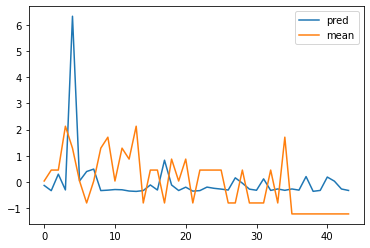

1505


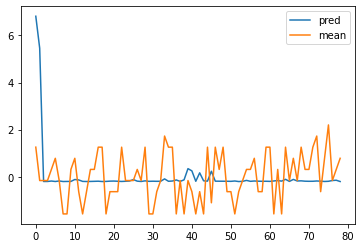

1755


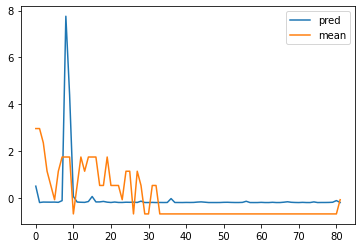

1781


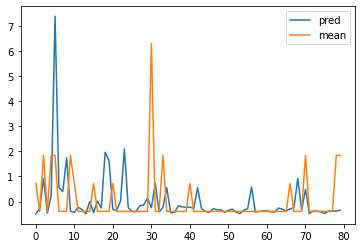

1774


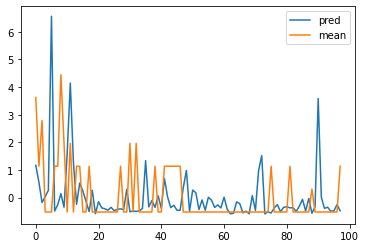

1773


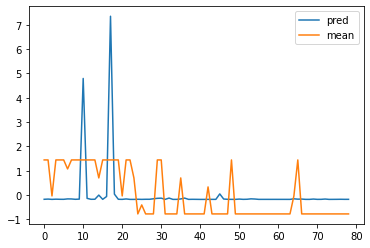

In [91]:
from sklearn.preprocessing import StandardScaler


score_df = pd.DataFrame(index=users, columns=['mean'])
whole_weight_df = pd.DataFrame(columns=['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
                'DeepSleepRate'])

for user_id in users:
    print(user_id)
    _X = create_user_feature(user_id).drop(['UserID', 'Score'], axis=1)
    _y = create_y(user_id)
    df = pd.merge(_X, _y, how='inner', on='TargetDate')
    _X = df[['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
                'DeepSleepRate']]
    _X = _X.fillna(_X.mean())
    for n in range(7, len(df)):
        X = _X.iloc[:n]
        y = _y['y'].iloc[:n]
        X_test = _X.iloc[[n]]
        # 正常データのみを使用して標準化
        scaler = StandardScaler()
        if len(X[y == 0]) > 3:
            scaler.fit(X[y == 0])
            normal_Z = scaler.transform(X[y == 0])
            if len(X[y == 1]) > 0:
                anomaly_Z = scaler.transform(X[y == 1])    # 正常データのみを使用して共分散行列を計算
            inv_C = inv_cov(normal_Z)
            # 異常データと直交表を用いてSN比を計算
            #L8直行表
            l8 = np.array([
                [1,1,1,1,1,1,1],
                [1,1,1,2,2,2,2],
                [1,2,2,1,1,2,2],
                [1,2,2,2,2,1,1],
                [2,1,2,1,2,1,2],
                [2,1,2,2,1,2,1],
                [2,2,1,1,2,2,1],
                [2,2,1,2,1,1,2]
                ])
            l8 = (l8 == 1)
            l8 = l8[:len(X.columns), :len(X.columns)]

            if len(X[y == 1]) > 0:
                #異常データのマハラノビス距離
                result = np.zeros((l8.shape[0], anomaly_Z.shape[0]))
                for i, l8_row in enumerate(l8):
                    result[i] = cal_MD(anomaly_Z[:, l8_row], inv_C[l8_row][:,l8_row])

                #SN比
                sn = np.zeros(l8.shape[0])
                for idx, row in enumerate(result):
                    sum_MD = 0
                    for i in range(len(row)):
                        sum_MD += 1 / row[i]
                    sn[idx] = -10 * math.log10(sum_MD / len(row))
                    
                # SN比を利用し，不要と思われる変数を削除する
                # 変数選択
                df_gain = pd.DataFrame(index=X.columns, columns=['効果ゲイン','残す'])
                for i, clm in enumerate(X.columns):
                    gain = sum(sn[l8.T[i]]) - sum(sn[~l8.T[i]])
                    df_gain.loc[df_gain.index == clm, '効果ゲイン'] = gain
                    df_gain.loc[df_gain.index == clm, '残す'] = gain > 0
                # 選択された変数を保存
                select_columns = X.columns
                
                select_gain = df_gain['効果ゲイン'].values
                
                select_columns_weight = (select_gain - select_gain.min()) / (select_gain.max() - select_gain.min())
                # 選択変数でのスケーラーと共分散行列を計算
                result_scaler = StandardScaler()
                result_scaler.fit(X[select_columns][y == 0])
                result_Z = result_scaler.transform(X[select_columns][y == 0])
                result_inv_C = inv_cov(result_Z)
                
                proba, _ = predict_WMTS(X_test, result_scaler, result_inv_C, select_columns, select_columns_weight, threshold=0)
                df.loc[n, 'pred'] = list(proba)[0]
                whole_weight_df = whole_weight_df.append(pd.Series(data=select_columns_weight, index=select_columns), ignore_index=True)
                
            else:
                result_scaler = scaler
                result_inv_C = inv_C
                select_columns = X.columns
                df.loc[n, 'pred'] = list(predict_MD(X_test, result_scaler, result_inv_C, select_columns))[0]
        else:
            scaler.fit(X)
            Z = scaler.transform(X)
            inv_C = inv_cov(Z)
            _Z = scaler.transform(X_test)
            md = np.dot(_Z, inv_C)
            MD = np.dot(md, _Z.T) / _Z.shape[1]
            df.loc[n, 'pred'] = MD[0][0]
    scaler = StandardScaler()
    plt.plot(scaler.fit_transform(df[['pred', 'mean']].iloc[7:]))
    plt.legend(['pred', 'mean'])
    plt.show()
    score_df.loc[user_id] = df[['pred', 'mean']].iloc[7:].corr().iloc[0][1]

In [92]:
score_df

,mean
1504,0.123605
1505,0.08922
1755,0.299146
1781,0.163747
1774,0.057045
1773,0.236057


In [93]:
score_df.mean()

mean    0.16147
dtype: float64

In [94]:
whole_weight_df.mean()

DiffRestHrValue     0.112480
DiffWakedHrValue    0.751274
StressCount         0.751274
DeepSleepRate       0.841811
dtype: float64

In [103]:
row

array([3.83610174e-01, 5.75810632e-01, 3.83610174e-01, 3.83610174e-01,
       2.39451251e+01, 3.83610174e-01, 3.83610174e-01, 3.83610174e-01,
       3.83610174e-01, 3.83610174e-01, 3.83610174e-01, 3.83610174e-01,
       3.83610174e-01, 3.83610174e-01, 4.11590417e+03, 1.23998611e+03,
       4.56679660e+00, 5.75810632e-01, 3.83610174e-01, 1.08287208e+02,
       4.66350589e+03, 1.73250963e+02, 3.83610174e-01, 3.83610174e-01,
       5.75810632e-01, 5.75810632e-01, 5.75810632e-01, 5.75810632e-01,
       3.83610174e-01])

1504


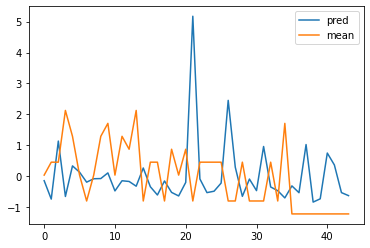

1505


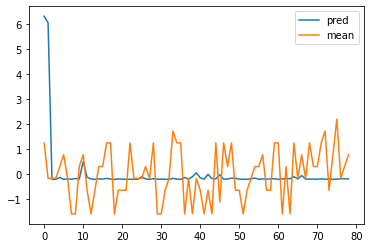

1755


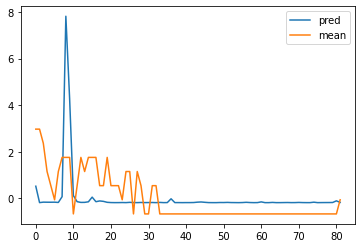

1781


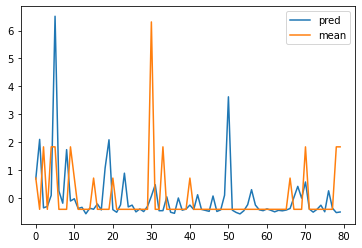

1774


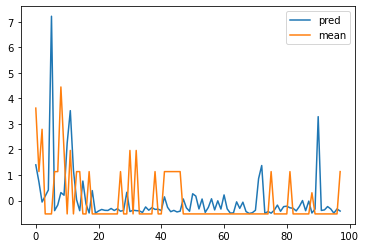

1773


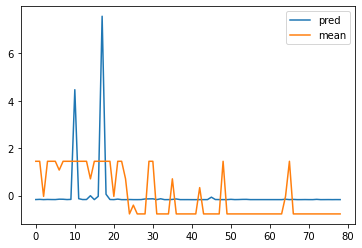

In [104]:
from sklearn.preprocessing import StandardScaler


score_df = pd.DataFrame(index=users, columns=['mean'])
weight_df_dict = {}

for user_id in users:
    weight_df = pd.DataFrame(columns=['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount', 'DeepSleepRate'])
    print(user_id)
    _X = create_user_feature(user_id).drop(['UserID', 'Score'], axis=1)
    _y = create_y(user_id)
    df = pd.merge(_X, _y, how='inner', on='TargetDate')
    _X = df[['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount', 'DeepSleepRate']]
    _X = _X.fillna(_X.mean())
    for n in range(7, len(df)):
        X = _X.iloc[:n]
        y = _y['y'].iloc[:n]
        X_test = _X.iloc[[n]]
        # 正常データのみを使用して標準化
        scaler = StandardScaler()
        if len(X[y == 0]) > 3:
            scaler.fit(X[y == 0])
            normal_Z = scaler.transform(X[y == 0])
            if len(X[y == 1]) > 0:
                anomaly_Z = scaler.transform(X[y == 1])    # 正常データのみを使用して共分散行列を計算
            inv_C = inv_cov(normal_Z)
            # 異常データと直交表を用いてSN比を計算
            #L8直行表
            l8 = np.array([
                [1,1,1,1,1,1,1],
                [1,1,1,2,2,2,2],
                [1,2,2,1,1,2,2],
                [1,2,2,2,2,1,1],
                [2,1,2,1,2,1,2],
                [2,1,2,2,1,2,1],
                [2,2,1,1,2,2,1],
                [2,2,1,2,1,1,2]
                ])
            l8 = (l8 == 1)
            l8 = l8[:, :len(X.columns)]

            if len(X[y == 1]) > 0:
                #異常データのマハラノビス距離
                result = np.zeros((l8.shape[0], anomaly_Z.shape[0]))
                for i, l8_row in enumerate(l8):
                    result[i] = cal_MD(anomaly_Z[:, l8_row], inv_C[l8_row][:,l8_row])

                #SN比
                sn = np.zeros(l8.shape[0])
                for idx, row in enumerate(result):
                    sum_MD = 0
                    for i in range(len(row)):
                        sum_MD += 1 / (row[i]+1e-10)
                    sn[idx] = -10 * math.log10(sum_MD / len(row))
                    
                # SN比を利用し，不要と思われる変数を削除する
                # 変数選択
                df_gain = pd.DataFrame(index=X.columns, columns=['効果ゲイン','残す'])
                for i, clm in enumerate(X.columns):
                    gain = sum(sn[l8.T[i]]) - sum(sn[~l8.T[i]])
                    df_gain.loc[df_gain.index == clm, '効果ゲイン'] = gain
                    df_gain.loc[df_gain.index == clm, '残す'] = gain > 0
                # 選択された変数を保存
                select_columns = X.columns
                
                select_gain = df_gain['効果ゲイン'].values
                
                select_columns_weight = (select_gain - select_gain.min()) / (select_gain.max() - select_gain.min())
                # 選択変数でのスケーラーと共分散行列を計算
                result_scaler = StandardScaler()
                result_scaler.fit(X[select_columns][y == 0])
                result_Z = result_scaler.transform(X[select_columns][y == 0])
                result_inv_C = inv_cov(result_Z)
                
                proba, _ = predict_WMTS(X_test, result_scaler, result_inv_C, select_columns, select_columns_weight, threshold=0)
                df.loc[n, 'pred'] = list(proba)[0]
                weight_df = weight_df.append(pd.Series(data=select_columns_weight, index=select_columns), ignore_index=True)
                
            else:
                result_scaler = scaler
                result_inv_C = inv_C
                select_columns = X.columns
                df.loc[n, 'pred'] = list(predict_MD(X_test, result_scaler, result_inv_C, select_columns))[0]
        else:
            scaler.fit(X)
            Z = scaler.transform(X)
            inv_C = inv_cov(Z)
            _Z = scaler.transform(X_test)
            md = np.dot(_Z, inv_C)
            MD = np.dot(md, _Z.T) / _Z.shape[1]
            df.loc[n, 'pred'] = MD[0][0]
    scaler = StandardScaler()
    plt.plot(scaler.fit_transform(df[['pred', 'mean']].iloc[7:]))
    plt.legend(['pred', 'mean'])
    plt.show()
    score_df.loc[user_id] = df[['pred', 'mean']].iloc[7:].corr().iloc[0][1]
    weight_df_dict[user_id] = weight_df

In [105]:
score_df

,mean
1504,-0.21699
1505,0.092918
1755,0.301931
1781,0.145843
1774,0.066861
1773,0.235495


In [106]:
score_df.mean()

mean    0.104343
dtype: float64

In [107]:
weight_df_dict[users[1]]

,DiffRestHrValue,DiffWakedHrValue,StressCount,DeepSleepRate
0,1.000000,0.771436,0.138804,0.000000
1,1.000000,0.574470,0.000000,0.370871
2,0.535154,1.000000,0.000000,0.085459
3,0.637948,1.000000,0.000000,0.150201
4,0.627853,1.000000,0.000000,0.161082
...,...,...,...,...
74,1.000000,0.432768,0.000000,0.500980
75,1.000000,0.536249,0.000000,0.501279
76,1.000000,0.629551,0.000000,0.515567
77,1.000000,0.621360,0.000000,0.517391


In [108]:
all_user_mean_weight_df = pd.DataFrame(index=users, columns=['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount', 'DeepSleepRate'])
for user_id in users:
    all_user_mean_weight_df.loc[user_id] = weight_df_dict[user_id].mean()
all_user_mean_weight_df

,DiffRestHrValue,DiffWakedHrValue,StressCount,DeepSleepRate
1504,0.906758,0.014177,0.648358,0.824069
1505,0.823086,0.497287,0.374216,0.677382
1755,0.626637,0.426983,0.453165,0.582317
1781,0.925728,0.071464,0.346723,0.953914
1774,0.172438,0.582305,0.642023,0.777533
1773,0.113154,0.33561,0.910089,0.969196


In [109]:

all_user_mean_weight_df.loc['mean'] = all_user_mean_weight_df.mean()
all_user_mean_weight_df

,DiffRestHrValue,DiffWakedHrValue,StressCount,DeepSleepRate
1504,0.906758,0.014177,0.648358,0.824069
1505,0.823086,0.497287,0.374216,0.677382
1755,0.626637,0.426983,0.453165,0.582317
1781,0.925728,0.071464,0.346723,0.953914
1774,0.172438,0.582305,0.642023,0.777533
1773,0.113154,0.33561,0.910089,0.969196
mean,0.594633,0.321304,0.562429,0.797402


In [110]:
all_user_mean_weight_df.mean()

DiffRestHrValue     0.594633
DiffWakedHrValue    0.321304
StressCount         0.562429
DeepSleepRate       0.797402
dtype: float64

In [111]:
all_user_mean_weight_df.agg(['mean', 'std']).T

,mean,std
DiffRestHrValue,0.594633,0.334248
DiffWakedHrValue,0.321304,0.211034
StressCount,0.562429,0.195140
DeepSleepRate,0.797402,0.138913


In [16]:
whole_weight_df.mean()

DiffRestHrValue     0.112480
DiffWakedHrValue    0.751274
StressCount         0.751274
DeepSleepRate       0.841811
dtype: float64

1504


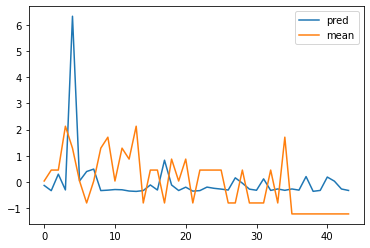

1505


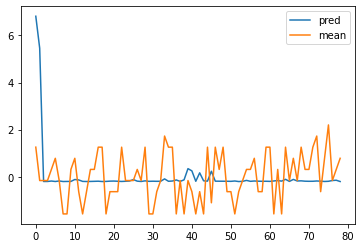

1755


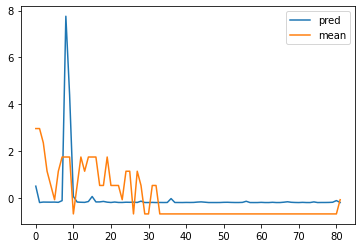

1781


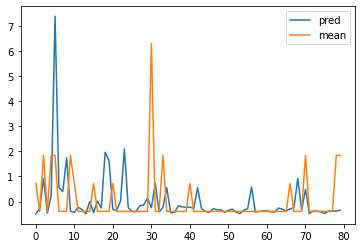

1774


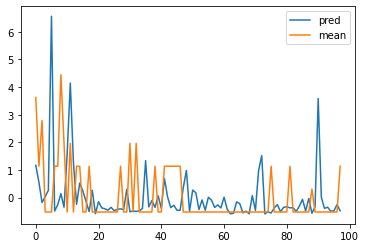

1773


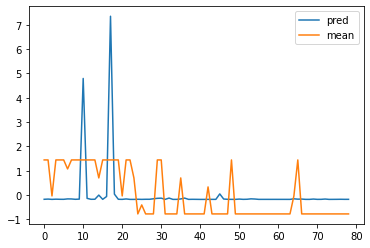

In [17]:
from sklearn.preprocessing import StandardScaler


score_df = pd.DataFrame(index=users, columns=['mean'])
weight_df_dict = {}

for user_id in users:
    weight_df = pd.DataFrame(columns=['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
                'DeepSleepRate'])
    print(user_id)
    _X = create_user_feature(user_id).drop(['UserID', 'Score'], axis=1)
    _y = create_y(user_id)
    df = pd.merge(_X, _y, how='inner', on='TargetDate')
    _X = df[['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
                'DeepSleepRate']]
    _X = _X.fillna(_X.mean())
    for n in range(7, len(df)):
        X = _X.iloc[:n]
        y = _y['y'].iloc[:n]
        X_test = _X.iloc[[n]]
        # 正常データのみを使用して標準化
        scaler = StandardScaler()
        if len(X[y == 0]) > 3:
            scaler.fit(X[y == 0])
            normal_Z = scaler.transform(X[y == 0])
            if len(X[y == 1]) > 0:
                anomaly_Z = scaler.transform(X[y == 1])    # 正常データのみを使用して共分散行列を計算
            inv_C = inv_cov(normal_Z)
            # 異常データと直交表を用いてSN比を計算
            #L8直行表
            l8 = np.array([
                [1,1,1,1,1,1,1],
                [1,1,1,2,2,2,2],
                [1,2,2,1,1,2,2],
                [1,2,2,2,2,1,1],
                [2,1,2,1,2,1,2],
                [2,1,2,2,1,2,1],
                [2,2,1,1,2,2,1],
                [2,2,1,2,1,1,2]
                ])
            l8 = (l8 == 1)
            l8 = l8[:len(X.columns), :len(X.columns)]

            if len(X[y == 1]) > 0:
                #異常データのマハラノビス距離
                result = np.zeros((l8.shape[0], anomaly_Z.shape[0]))
                for i, l8_row in enumerate(l8):
                    result[i] = cal_MD(anomaly_Z[:, l8_row], inv_C[l8_row][:,l8_row])

                #SN比
                sn = np.zeros(l8.shape[0])
                for idx, row in enumerate(result):
                    sum_MD = 0
                    for i in range(len(row)):
                        sum_MD += 1 / row[i]
                    sn[idx] = -10 * math.log10(sum_MD / len(row))
                    
                # SN比を利用し，不要と思われる変数を削除する
                # 変数選択
                df_gain = pd.DataFrame(index=X.columns, columns=['効果ゲイン','残す'])
                for i, clm in enumerate(X.columns):
                    gain = sum(sn[l8.T[i]]) - sum(sn[~l8.T[i]])
                    df_gain.loc[df_gain.index == clm, '効果ゲイン'] = gain
                    df_gain.loc[df_gain.index == clm, '残す'] = gain > 0
                # 選択された変数を保存
                select_columns = X.columns
                
                select_gain = df_gain['効果ゲイン'].values
                
                select_columns_weight = (select_gain - select_gain.min()) / (select_gain.max() - select_gain.min())
                # 選択変数でのスケーラーと共分散行列を計算
                result_scaler = StandardScaler()
                result_scaler.fit(X[select_columns][y == 0])
                result_Z = result_scaler.transform(X[select_columns][y == 0])
                result_inv_C = inv_cov(result_Z)
                
                proba, _ = predict_WMTS(X_test, result_scaler, result_inv_C, select_columns, select_columns_weight, threshold=0)
                df.loc[n, 'pred'] = list(proba)[0]
                if n > len(df)-10:
                    weight_df = weight_df.append(pd.Series(data=select_columns_weight, index=select_columns), ignore_index=True)
                
            else:
                result_scaler = scaler
                result_inv_C = inv_C
                select_columns = X.columns
                df.loc[n, 'pred'] = list(predict_MD(X_test, result_scaler, result_inv_C, select_columns))[0]
        else:
            scaler.fit(X)
            Z = scaler.transform(X)
            inv_C = inv_cov(Z)
            _Z = scaler.transform(X_test)
            md = np.dot(_Z, inv_C)
            MD = np.dot(md, _Z.T) / _Z.shape[1]
            df.loc[n, 'pred'] = MD[0][0]
    scaler = StandardScaler()
    plt.plot(scaler.fit_transform(df[['pred', 'mean']].iloc[7:]))
    plt.legend(['pred', 'mean'])
    plt.show()
    score_df.loc[user_id] = df[['pred', 'mean']].iloc[7:].corr().iloc[0][1]
    weight_df_dict[user_id] = weight_df

In [18]:
all_user_mean_weight_df = pd.DataFrame(index=users, columns=['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount', 'DeepSleepRate'])
for user_id in users:
    all_user_mean_weight_df.loc[user_id] = weight_df_dict[user_id].mean()
all_user_mean_weight_df

,DiffRestHrValue,DiffWakedHrValue,StressCount,DeepSleepRate
1504,0.0,0.687014,0.687014,1.0
1505,0.0,0.976551,0.976551,0.898049
1755,0.0,1.0,1.0,0.842309
1781,0.0,0.241402,0.241402,1.0
1774,0.0,1.0,1.0,0.75113
1773,0.0,1.0,1.0,0.956068


In [19]:
all_user_mean_weight_df.mean()

DiffRestHrValue     0.000000
DiffWakedHrValue    0.817495
StressCount         0.817495
DeepSleepRate       0.907926
dtype: float64

In [20]:
all_user_mean_weight_df.agg(['mean', 'std']).T

,mean,std
DiffRestHrValue,0.000000,0.000000
DiffWakedHrValue,0.817495,0.307939
StressCount,0.817495,0.307939
DeepSleepRate,0.907926,0.098246
